In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from keras.models import Sequential
from keras import Model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

from IPython.core.interactiveshell import InteractiveShell
from IPython import display
InteractiveShell.ast_node_interactivity = "all"

import os
import pickle
import time

import PIL
import PIL.Image as Image
print('Pillow Version',PIL.__version__)

Pillow Version 7.0.0


Set Random Seeds

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

(300, 256, 256, 3)

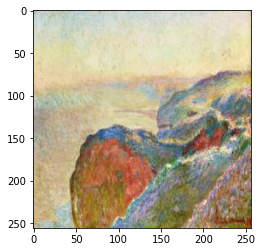

In [35]:
with open('monet.txt','rb') as read_file:
  monet_list = pickle.load(read_file)

monet_array = np.array(monet_list)
monet_array.shape

plt.imshow(monet_array[0])
plt.show()

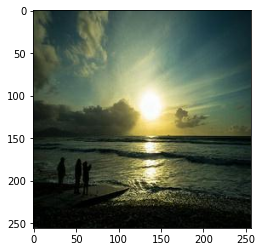

(300, 256, 256, 3)

In [36]:
with open('photo300.txt','rb') as read_file:
  photo_list = pickle.load(read_file)

plt.imshow(photo_list[0])
plt.show()

photo_array = np.array(photo_list)
photo_array.shape

Data Preparation

In [37]:
train_monet, test_monet = train_test_split(monet_array, test_size=0.2, random_state=42)

train_monet.shape
test_monet.shape

(240, 256, 256, 3)

(60, 256, 256, 3)

In [38]:
train_photo = photo_array
train_photo.shape

(300, 256, 256, 3)

In [39]:
def normalize(image):
  image_scaled = image.astype('float32')
  image_scaled = image_scaled / 255.
  #image_scaled = (image_scaled / 127.5) - 1
  return image_scaled

train_monet_scaled = normalize(train_monet)
test_monet_scaled = normalize(test_monet)

train_photo_scaled = normalize(train_photo)

Conv AE

In [40]:
conv_encodeer = Sequential([
    layers.Conv2D(16, kernel_size=3, strides=2, padding="same", input_shape=[256, 256, 3]),
    layers.BatchNormalization(),
    layers.LeakyReLU(), 
    layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
])

conv_encodeer.summary()

conv_decoder = Sequential([
    layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", input_shape=[16, 16, 128]),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
])

conv_decoder.summary()

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

conv_ae = Sequential([conv_encodeer, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam())

history = conv_ae.fit(train_monet_scaled, train_monet_scaled, validation_data=(test_monet_scaled, test_monet_scaled), epochs=100, callbacks=[early_stopping])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_37 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)      

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

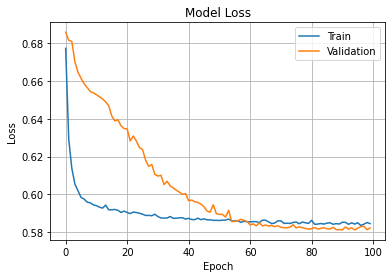

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

Helper functions for visualizing original vs reconstructed images

In [42]:
def visualize_reconstruction(model, origin_image, scaled_image, n_images):

    recon_img = model.predict(scaled_image[:n_images])

    for image_i in range(n_images):
      plt.subplot(1,2,1)
      plt.title("Original")
      plt.imshow(origin_image[image_i])

      plt.subplot(1,2,2)
      plt.title("Reconstructed")
      plt.imshow(recon_img[image_i])
      plt.show()


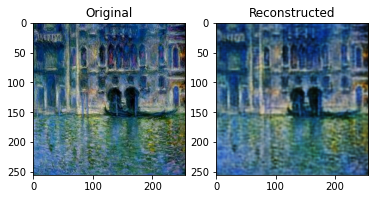

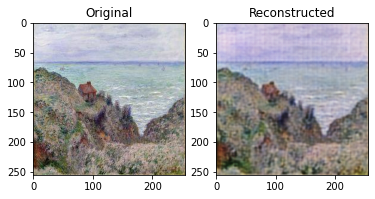

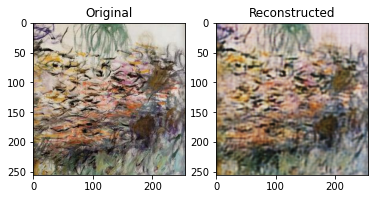

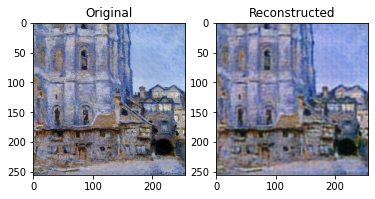

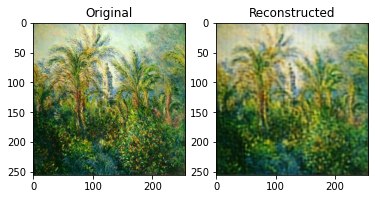

In [43]:
visualize_reconstruction(conv_ae, test_monet, test_monet_scaled, 5)